Ссылка на данные: https://drive.google.com/drive/folders/1Nm1XbW95qb-5AGv4yIvAkCuAQC9CXiOc?usp=sharing

In [ ]:
%%capture
!wget -O train.csv https://www.dropbox.com/scl/fi/ezyhyffeebua7xyawouhh/train.csv?rlkey=ow1pw3xztuzesoxt8qimft2uf&dl=0
!wget -O test.csv https://www.dropbox.com/scl/fi/aujx45s77gk9u4naxwanf/test.csv?rlkey=sk2dtqej0fugdwgc8q25ki36h&dl=0

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import pandas as pd
from tqdm import tqdm_notebook
import cv2
from IPython.display import clear_output

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score

EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
N_CLASSES = len(EMOTIONS)

torch.set_float32_matmul_precision("medium")

In [ ]:
# каждое изображение растянуто в строку в таблице
# преобразуем в привычный массив, не создавая папки с изображениями явным образом,
# т.к. метод .fit() работает гораздо быстрее чем .fit_generator()
# для контроля переобучения выделите из X_train, y_train данные для валидации

img_width, img_height = (48,48)

def str_to_image(image_blob):
    image_string = image_blob[0].split(' ')
    image_data = np.asarray(image_string, dtype=np.uint8).reshape(48,48)
    return image_data

def csv_to_array(csv):
    X = csv.pixels.values
    X = np.apply_along_axis(str_to_image, 1, X[:,None])/255.
    X = X[:, None, :, :]
    return X

train = pd.read_csv('train.csv') # для обучения и валидации
test = pd.read_csv('test.csv') # для сабмита на кагл

y_train = train.emotion.values
X_train = csv_to_array(train)
X_test= csv_to_array(test)

# X_val, y_val = ... # Ваш код здесь

In [ ]:
X_train.shape, y_train.shape

((28709, 1, 48, 48), (28709,))

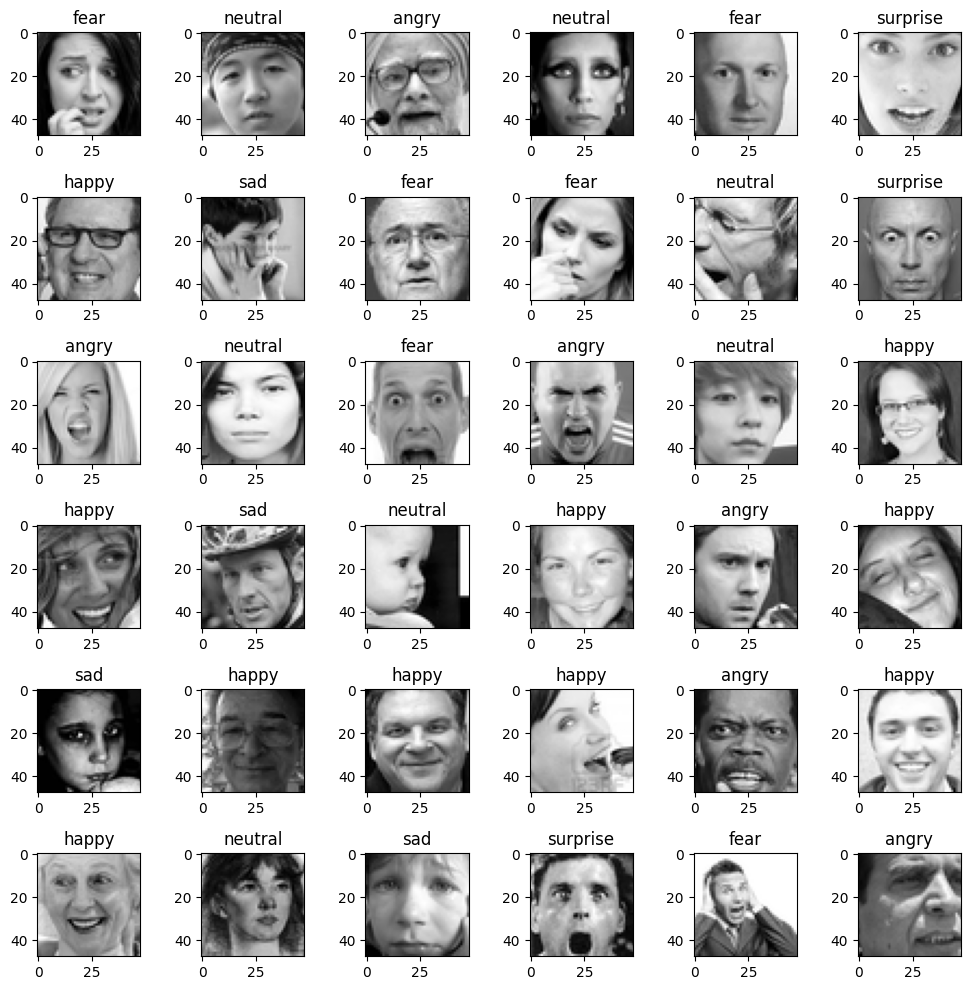

In [ ]:
# посмотрим как выглядят изображения
N_IMAGES_TO_PLOT = 36
fig, axes = plt.subplots(nrows=np.sqrt(N_IMAGES_TO_PLOT).astype(int),
                         ncols = np.sqrt(N_IMAGES_TO_PLOT).astype(int),
                         figsize=(10,10))

rand_indx = np.random.choice(np.arange(N_IMAGES_TO_PLOT), size=N_IMAGES_TO_PLOT, replace=False)
for ax, emotion_index, img in zip(axes.flatten(), train.emotion.values[rand_indx], X_train[rand_indx]):
    img = img[0,:,:] # [1, 48,48] -> [48,48]
    ax.imshow(img, cmap='gray')
    emotion = EMOTIONS[emotion_index]
    ax.set_title(emotion)
plt.tight_layout()
plt.show()

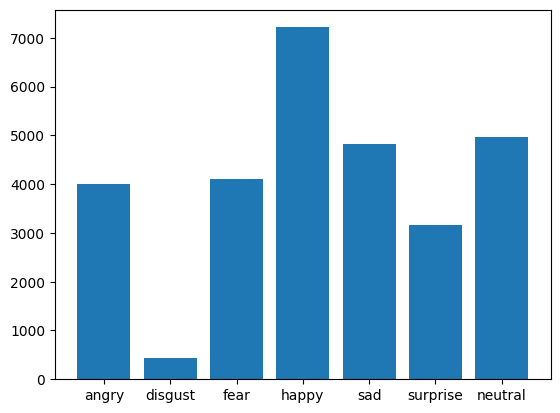

In [ ]:
# посмотрим насколько сбалансированны классы в обучающей выборке
train_count = train.groupby('emotion').count()
plt.bar(x = EMOTIONS,
        height=train_count.values.flatten())
plt.show()

Виден сильный дисбаланс между классом `disguist` и остальными

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

Создаем класс датасета и даталоадера для нашей обучающей выборки

In [ ]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

X_test_tensor = torch.Tensor(X_test)

Базовая модель:

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.Linear(3200, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, N_CLASSES),
).to(device)

Функции для обучения:

In [ ]:
# функция обучения одной эпохи
def train_step(model, train_dataloader, optimizer, criterion):

    model.train() # переводим модель в режим тренировки

    # сохраняем различные статистики внутри эпохи
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # итерация по батчам в датасете
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        # перемещение данных на GPU
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)

        # обнуление градиентов
        # без данной строчки, торч просто добавит их к предыдущим
        optimizer.zero_grad()

        # прямой проход
        outputs = model(inputs) # передаем изображения в модель
        loss = criterion(outputs, labels) # считаем функцию потерь
        loss.backward() # применяем обратное распространение ошибки
        optimizer.step() # делаем шаг обучения

        # статистика для вывода
        running_loss += loss.item()
        predicted = torch.argmax(outputs.data, dim=1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # вычисление среднего значения потерь и точности на эпохе
    train_accuracy = correct_predictions / total_samples
    average_loss = running_loss / len(train_dataloader)

    return average_loss, train_accuracy

# общая функция ддя обучения
def train_model(model, train_dataloader, optimizer, criterion, num_epochs=8):
    # будем складывать accuracy на каждой эпохе
    train_accuracy_history = []
    train_loss_history = []

    for epoch in range(num_epochs): # итерируемся по эпохам
        # шаг обучения
        average_loss, train_accuracy = train_step(model, train_dataloader, optimizer, criterion)
        train_accuracy_history.append(train_accuracy)
        train_loss_history.append(average_loss)

        # вывод результатов
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Loss: {average_loss:.4f} | Train Accuracy: {train_accuracy:.4f}')

    return train_accuracy_history, train_loss_history

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
train_accuracy_history, train_loss_history = train_model(model,train_dataloader, optimizer, criterion, 25)

Epoch 1/25
Loss: 1.7545 | Train Accuracy: 0.2840
Epoch 2/25
Loss: 1.5888 | Train Accuracy: 0.3801
Epoch 3/25
Loss: 1.4705 | Train Accuracy: 0.4348
Epoch 4/25
Loss: 1.3900 | Train Accuracy: 0.4664
Epoch 5/25
Loss: 1.3279 | Train Accuracy: 0.4939
Epoch 6/25
Loss: 1.2759 | Train Accuracy: 0.5161
Epoch 7/25
Loss: 1.2283 | Train Accuracy: 0.5356
Epoch 8/25
Loss: 1.1857 | Train Accuracy: 0.5509
Epoch 9/25
Loss: 1.1526 | Train Accuracy: 0.5626
Epoch 10/25
Loss: 1.1172 | Train Accuracy: 0.5807
Epoch 11/25
Loss: 1.0817 | Train Accuracy: 0.5939
Epoch 12/25
Loss: 1.0412 | Train Accuracy: 0.6098
Epoch 13/25
Loss: 1.0069 | Train Accuracy: 0.6233
Epoch 14/25
Loss: 0.9692 | Train Accuracy: 0.6374
Epoch 15/25
Loss: 0.9360 | Train Accuracy: 0.6507
Epoch 16/25
Loss: 0.9031 | Train Accuracy: 0.6641
Epoch 17/25
Loss: 0.8638 | Train Accuracy: 0.6775
Epoch 18/25
Loss: 0.8357 | Train Accuracy: 0.6892
Epoch 19/25
Loss: 0.7980 | Train Accuracy: 0.6986
Epoch 20/25
Loss: 0.7709 | Train Accuracy: 0.7101
Epoch 21/

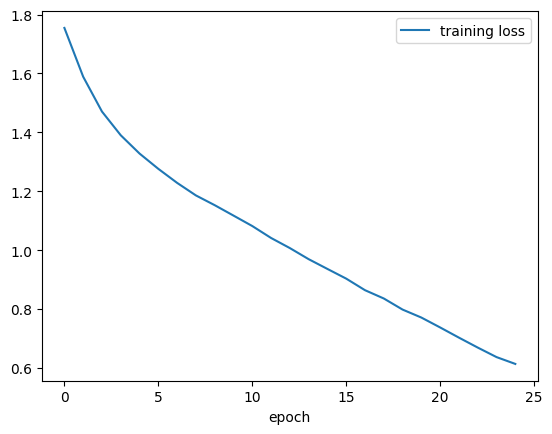

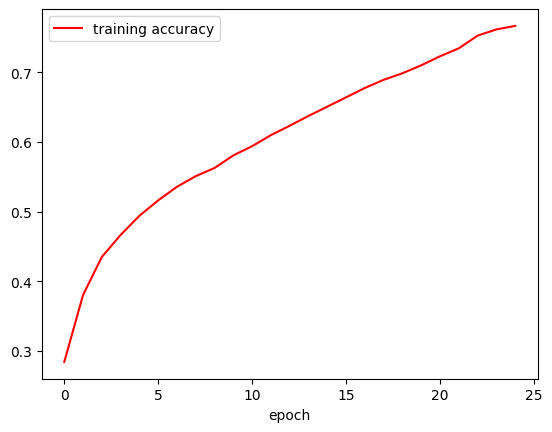

In [ ]:
plt.figure()
plt.plot(train_loss_history, label='training loss')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(train_accuracy_history, color='r', label='training accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

### Как сделать лучше?

 - Начните со сверточной нейронной сети: Conv2D -> Activation ReLU -> Conv2D ... -> Dense
 - Transfer Learning: взять предобученную на большом датасете модель и слегка дообучить ее, подстроив под новую задачу. Это возможно, т.к. большая часть слоев нейронной сети, обученной для классификации изображений, извлекает признаки из изображения, а последний, линейный слой, выступает в роли классификатора. Подробнее о том как это использовать - [здесь](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
 - Аугментация данных: небольшой размер датасета и большое количество параметров модели (что характерно для нейронных сетей) способствует переобучению. Проблему недостатка данных можно решить трансформацией батча на этапе обучения, например, вращая изображения или меняя уровень яркости. Подробнее - [здесь](https://datagy.io/pytorch-transforms/)  
 - Попробуйте убрать дисбаланс в данных, использовав простой oversampling: например для каждого класса добавьте в него случайно выбранные из него-же данные.

In [ ]:
# вычисляет и скачивает файл для submission на kaggle
def submit(model, X_test):
    with torch.no_grad():
        model.eval()
        prediction=model(X_test.to(device))

        pred_classes = prediction.cpu().argmax(-1)
        df = pd.DataFrame(data = {'Id':np.arange(len(pred_classes)),
                                  'Category':pred_classes})

        df.to_csv('submission.csv', index=False)
        files.download('submission.csv')

submit(model, X_test_tensor)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>